In [10]:
%load_ext autoreload
%autoreload 2

from functools import partial
import numpy as np
import keras
import os

from distributions import ZeroInflatedDist, QuantizedNormal
from plotting_funcs import sample_and_plot, plot_dist, plot_hexagon_grid

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt


seed = 360

from datasets import make_data, train_val_test_split, tensorflow_dataset
from models import poisson_glm, mixture_poissons, mixture_poissons2
from metrics import poisson_nll, get_bpr_loss_func, get_penalized_bpr_loss_func, top_k_idx, mixture_poi_loss, get_penalized_bpr_loss_func_mix, mix_bpr
tf.config.run_functions_eagerly(True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


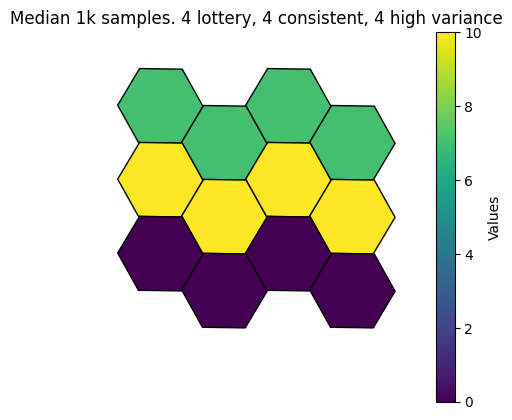

In [27]:
# tracts/distributions
S=12
# history/features
H = 50
# total timepoints
T= 500
# K for bpr
K=3
num_components=4

input_shape = (H,S)

consistent_4 = [QuantizedNormal(7, 0.1) for _ in range(4)]

highvar_4 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 1-0.7) for _ in range(4)]

powerball_4 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(4)]
dist_S = consistent_4 + highvar_4 +powerball_4

sample_and_plot(dist_S, size=1000, median=True, title='Median 1k samples. 4 lottery, 4 consistent, 4 high variance')


X_THS, y_TS = make_data(dist_S, H=H, T=T, seed=360)

# check that each final history is equal to the previous observation
for t in range(H, T):
    assert(np.all(X_THS[t, H-1, :] == y_TS[t-1, :]))

# check random point in history
for t in range(H, T):
    h = np.random.randint(0, H)
    assert(np.all(X_THS[t, h, :] == y_TS[t-(H-h), :]))

(train_X_THS, train_y_TS), \
(val_X_THS, val_y_TS), \
(test_X_THS, test_y_TS) = train_val_test_split(X_THS, y_TS, train_pct=0.6, test_pct=0.2)

train_dataset = tensorflow_dataset(train_X_THS, train_y_TS, seed=seed+200,batch_size=100)
val_dataset = tensorflow_dataset(val_X_THS, val_y_TS, seed=seed+300,batch_size=100)

In [35]:
mix_model, mix_weights  = mixture_poissons(input_shape, num_components=num_components)

In [36]:
# penalty = 0 for NLL only
penalty = 0
bpr_threshold = 0.45
learning_rate = 0.01

negative_bpr_K = get_bpr_loss_func(K)
penalized_bpr_loss = get_penalized_bpr_loss_func_mix(mixture_poi_loss, K, penalty, bpr_threshold)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [37]:
#mix_model.compile(optimizer=optimizer, loss=penalized_bpr_loss, metrics = [mix_bpr_metric, mixture_poi_loss])

In [38]:
preds = mix_model(train_X_THS)

In [39]:
def training_loop(model, loss_func, optimizer, num_epochs, verbose=False):

    losses = {}
    losses['train'] = {}
    losses['val'] ={}
    losses['train']['loss']=[]
    losses['train']['nll']=[]
    losses['train']['bpr']=[]
    losses['val']['loss']=[]
    losses['val']['nll']=[]
    losses['val']['bpr']=[]

    for epoch in range(num_epochs):

        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:
                y_preds = model(x_batch_train, training=True)
                loss_value = loss_func(y_batch_train, y_preds)
                
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        y_preds = model(train_X_THS)
        loss = loss_func(train_y_TS, y_preds)
        loss = tf.reduce_mean(loss)
        bpr = mix_bpr(train_y_TS, y_preds, negative_bpr_K_func=negative_bpr_K)
        nll = mixture_poi_loss(train_y_TS, y_preds)
        nll = tf.reduce_mean(tf.reduce_sum(nll,axis=-1))
        losses['train']['loss'].append(loss)
        losses['train']['nll'].append(nll)
        losses['train']['bpr'].append(bpr)
        if verbose:
            print(f'{epoch}: {loss}')
        y_preds = model(val_X_THS)
        loss = loss_func(val_y_TS, y_preds)
        loss = tf.reduce_mean(loss)
        bpr = mix_bpr(val_y_TS, y_preds, negative_bpr_K_func=negative_bpr_K)
        nll = mixture_poi_loss(val_y_TS, y_preds)
        nll = tf.reduce_mean(tf.reduce_sum(nll,axis=-1))
        losses['val']['loss'].append(loss)
        losses['val']['nll'].append(nll)
        losses['val']['bpr'].append(bpr)

    return losses
    

In [40]:
losses = training_loop(mix_model, penalized_bpr_loss, optimizer, 100)


Start of epoch 0
tf.Tensor(552.69867, shape=(), dtype=float32)

Start of epoch 1
tf.Tensor(410.61816, shape=(), dtype=float32)

Start of epoch 2
tf.Tensor(369.36105, shape=(), dtype=float32)

Start of epoch 3
tf.Tensor(352.36453, shape=(), dtype=float32)

Start of epoch 4
tf.Tensor(340.38263, shape=(), dtype=float32)

Start of epoch 5
tf.Tensor(327.87106, shape=(), dtype=float32)

Start of epoch 6
tf.Tensor(314.39343, shape=(), dtype=float32)

Start of epoch 7
tf.Tensor(300.95428, shape=(), dtype=float32)

Start of epoch 8
tf.Tensor(285.43915, shape=(), dtype=float32)

Start of epoch 9
tf.Tensor(267.67197, shape=(), dtype=float32)

Start of epoch 10
tf.Tensor(249.09007, shape=(), dtype=float32)

Start of epoch 11
tf.Tensor(230.47893, shape=(), dtype=float32)

Start of epoch 12
tf.Tensor(213.5507, shape=(), dtype=float32)

Start of epoch 13
tf.Tensor(199.02254, shape=(), dtype=float32)

Start of epoch 14
tf.Tensor(186.5322, shape=(), dtype=float32)

Start of epoch 15
tf.Tensor(175.6429

In [58]:
def plot_losses(losses, title_add='', save_dir=None, file_add=''):
    # plot loss and metrics from history
    plt.plot(losses['train']['loss'])
    plt.plot(losses['val']['loss'])
    plt.title(f'Model loss {title_add}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, f'loss_{file_add}.png'))

    plt.plot(losses['train']['nll'])
    plt.plot(losses['val']['nll'])
    plt.title(f'Model NLL {title_add}')
    plt.ylabel('NLL')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, f'nll_{file_add}.png'))

    plt.plot(losses['train']['bpr'])
    plt.plot(losses['val']['bpr'])
    plt.title(f'Model Negative BPR {title_add}')
    plt.ylabel('Negative BPR')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, f'bpr_{file_add}.png'))


In [56]:
from functools import partial
val_preds, mix_weights = mix_model(val_X_THS)

mixture_weights = tf.ones((val_preds.shape[0],1)) * tf.squeeze(mix_weights)
dot_layer = keras.layers.Dot(axes=(1,-1))
mixture_pred = dot_layer([mixture_weights, val_preds])

# get one hot vector of top 3 values in val_preds
top_K_idx_func = partial(top_k_idx, k=K)
top_K_ids = top_K_idx_func(mixture_pred)
print(f'avg pred:{np.mean(top_K_ids, axis=0)}')
print(f'avg pred per component: {tf.reduce_mean(tf.map_fn(top_K_idx_func, tf.transpose(val_preds,(2,0,1))), axis=1)}')

avg pred:[0.12 0.03 0.01 0.   0.14 0.24 0.22 0.19 0.57 0.57 0.48 0.43]
avg pred per component: [[0.13 0.03 0.02 0.   0.12 0.22 0.22 0.21 0.55 0.52 0.54 0.44]
 [0.12 0.03 0.01 0.   0.15 0.25 0.22 0.2  0.57 0.55 0.47 0.43]
 [0.12 0.03 0.01 0.   0.15 0.25 0.22 0.21 0.57 0.53 0.48 0.43]
 [0.14 0.04 0.01 0.   0.14 0.26 0.22 0.18 0.56 0.57 0.45 0.43]]


In [57]:
mix_model, mix_weights  = mixture_poissons(input_shape, num_components=num_components)
# penalty = 500 for penalized objective 
penalty = 500
bpr_threshold = 0.45
learning_rate = 0.01

negative_bpr_K = get_bpr_loss_func(K)
penalized_bpr_loss = get_penalized_bpr_loss_func_mix(mixture_poi_loss, K, penalty, bpr_threshold)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

losses_penalized = training_loop(mix_model, penalized_bpr_loss, optimizer, 100)


Start of epoch 0
tf.Tensor(658.3053, shape=(), dtype=float32)

Start of epoch 1
tf.Tensor(511.3529, shape=(), dtype=float32)

Start of epoch 2
tf.Tensor(463.50912, shape=(), dtype=float32)

Start of epoch 3
tf.Tensor(444.22412, shape=(), dtype=float32)

Start of epoch 4
tf.Tensor(428.89835, shape=(), dtype=float32)

Start of epoch 5
tf.Tensor(413.85822, shape=(), dtype=float32)

Start of epoch 6
tf.Tensor(399.18924, shape=(), dtype=float32)

Start of epoch 7
tf.Tensor(383.18253, shape=(), dtype=float32)

Start of epoch 8
tf.Tensor(367.35324, shape=(), dtype=float32)

Start of epoch 9
tf.Tensor(352.09183, shape=(), dtype=float32)

Start of epoch 10
tf.Tensor(333.43677, shape=(), dtype=float32)

Start of epoch 11
tf.Tensor(312.53207, shape=(), dtype=float32)

Start of epoch 12
tf.Tensor(294.29022, shape=(), dtype=float32)

Start of epoch 13
tf.Tensor(278.08762, shape=(), dtype=float32)

Start of epoch 14
tf.Tensor(262.65662, shape=(), dtype=float32)

Start of epoch 15
tf.Tensor(247.4279

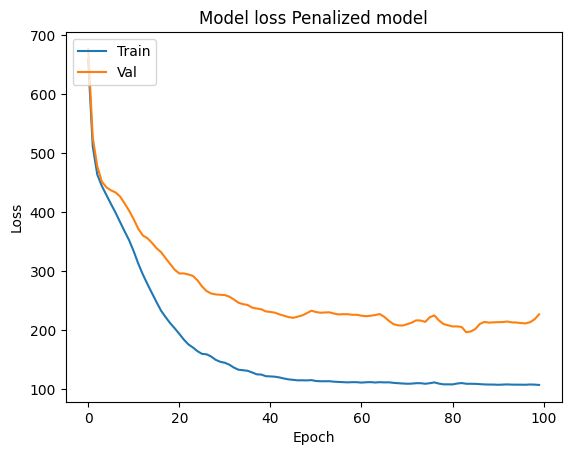

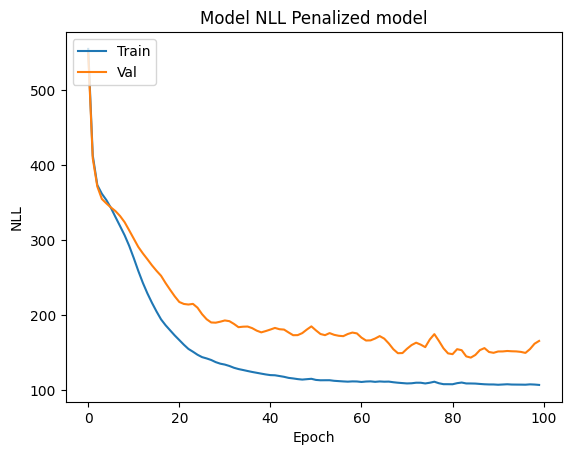

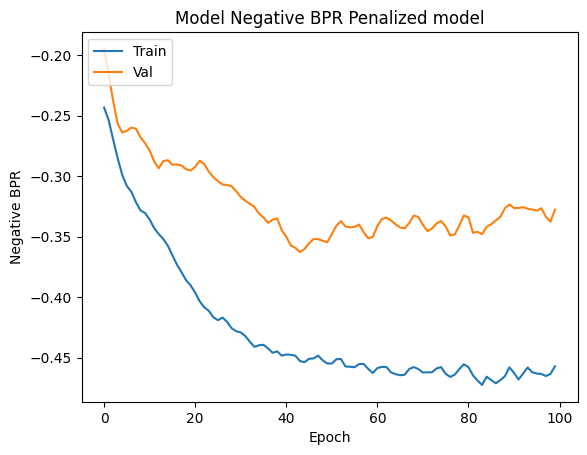

In [60]:
plot_losses(losses_penalized, 'Penalized model')

In [61]:
from functools import partial
val_preds, mix_weights = mix_model(val_X_THS)

mixture_weights = tf.ones((val_preds.shape[0],1)) * tf.squeeze(mix_weights)
dot_layer = keras.layers.Dot(axes=(1,-1))
mixture_pred = dot_layer([mixture_weights, val_preds])

# get one hot vector of top 3 values in val_preds
top_K_idx_func = partial(top_k_idx, k=K)
top_K_ids = top_K_idx_func(mixture_pred)
print(f'avg pred:{np.mean(top_K_ids, axis=0)}')
print(f'avg pred per component: {tf.reduce_mean(tf.map_fn(top_K_idx_func, tf.transpose(val_preds,(2,0,1))), axis=1)}')

avg pred:[0.17 0.04 0.   0.   0.14 0.23 0.24 0.22 0.5  0.53 0.51 0.42]
avg pred per component: [[0.19 0.03 0.   0.   0.15 0.27 0.25 0.17 0.53 0.54 0.49 0.38]
 [0.14 0.04 0.   0.   0.15 0.25 0.24 0.2  0.5  0.53 0.51 0.44]
 [0.16 0.04 0.   0.   0.15 0.24 0.24 0.21 0.49 0.52 0.51 0.44]
 [0.18 0.03 0.   0.   0.13 0.26 0.26 0.19 0.53 0.53 0.48 0.41]]



Start of epoch 0
tf.Tensor(-0.26250917, shape=(), dtype=float32)

Start of epoch 1
tf.Tensor(-0.2882908, shape=(), dtype=float32)

Start of epoch 2
tf.Tensor(-0.30679497, shape=(), dtype=float32)

Start of epoch 3
tf.Tensor(-0.32369322, shape=(), dtype=float32)

Start of epoch 4
tf.Tensor(-0.3354163, shape=(), dtype=float32)

Start of epoch 5
tf.Tensor(-0.34474602, shape=(), dtype=float32)

Start of epoch 6
tf.Tensor(-0.35269722, shape=(), dtype=float32)

Start of epoch 7
tf.Tensor(-0.3595072, shape=(), dtype=float32)

Start of epoch 8
tf.Tensor(-0.3657574, shape=(), dtype=float32)

Start of epoch 9
tf.Tensor(-0.3701406, shape=(), dtype=float32)

Start of epoch 10
tf.Tensor(-0.37617007, shape=(), dtype=float32)

Start of epoch 11
tf.Tensor(-0.38051873, shape=(), dtype=float32)

Start of epoch 12
tf.Tensor(-0.38422748, shape=(), dtype=float32)

Start of epoch 13
tf.Tensor(-0.38817796, shape=(), dtype=float32)

Start of epoch 14
tf.Tensor(-0.39218095, shape=(), dtype=float32)

Start of 

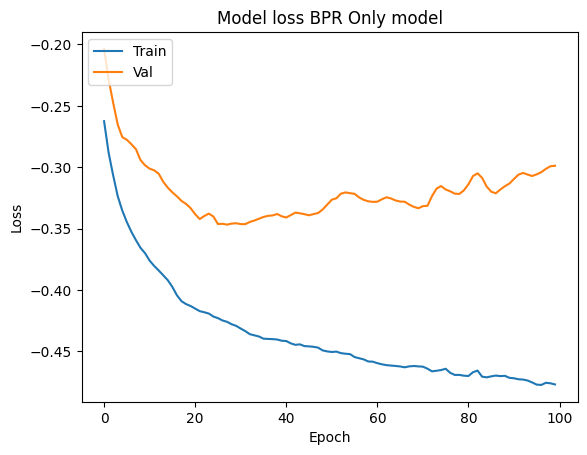

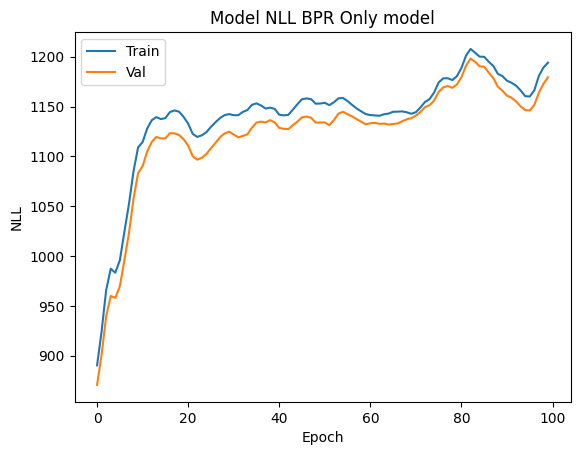

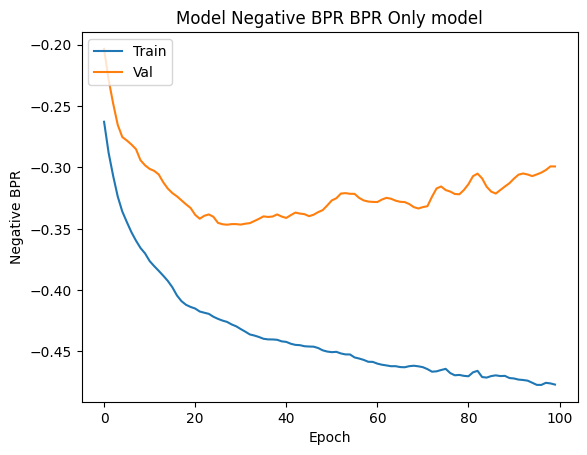

avg pred:[0.09 0.   0.   0.   0.2  0.2  0.2  0.2  0.53 0.52 0.5  0.56]
avg pred per component: [[0.1  0.03 0.   0.   0.47 0.23 0.23 0.27 0.4  0.38 0.38 0.51]
 [0.16 0.06 0.   0.   0.16 0.23 0.25 0.21 0.47 0.51 0.5  0.45]
 [0.09 0.02 0.   0.   0.24 0.23 0.25 0.26 0.52 0.49 0.46 0.44]
 [0.1  0.01 0.   0.   0.63 0.25 0.24 0.32 0.38 0.28 0.37 0.42]]


In [64]:
mix_model, mix_weights  = mixture_poissons(input_shape, num_components=num_components)
# penalty = 1 because BPR is only objective
penalty = 1
bpr_threshold = 0.45
learning_rate = 0.01

negative_bpr_K = get_bpr_loss_func(K)
bpr_only_loss = partial(mix_bpr, negative_bpr_K_func=negative_bpr_K)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

losses_bpr = training_loop(mix_model, bpr_only_loss, optimizer, 100)
plot_losses(losses_bpr, 'BPR Only model')
from functools import partial
val_preds, mix_weights = mix_model(val_X_THS)

mixture_weights = tf.ones((val_preds.shape[0],1)) * tf.squeeze(mix_weights)
dot_layer = keras.layers.Dot(axes=(1,-1))
mixture_pred = dot_layer([mixture_weights, val_preds])

# get one hot vector of top 3 values in val_preds
top_K_idx_func = partial(top_k_idx, k=K)
top_K_ids = top_K_idx_func(mixture_pred)
print(f'avg pred:{np.mean(top_K_ids, axis=0)}')
print(f'avg pred per component: {tf.reduce_mean(tf.map_fn(top_K_idx_func, tf.transpose(val_preds,(2,0,1))), axis=1)}')

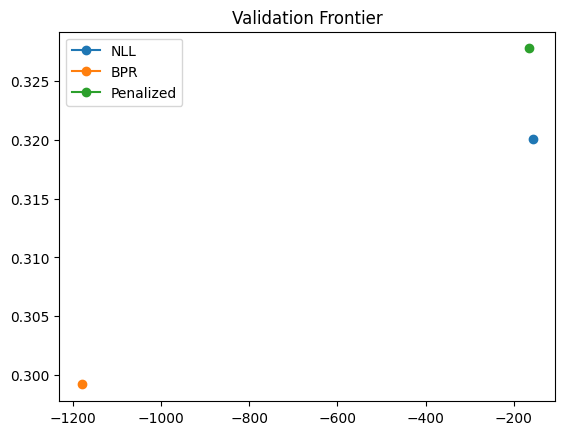

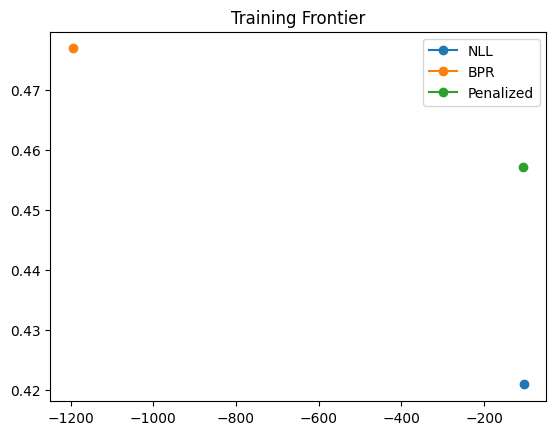

In [75]:
plt.plot(-np.array(losses['val']['nll'][-1]), -np.array(losses['val']['bpr'][-1]), marker='o', label='NLL')
plt.plot(-np.array(losses_bpr['val']['nll'][-1]), -np.array(losses_bpr['val']['bpr'][-1]), marker='o', label='BPR')
plt.plot(-np.array(losses_penalized['val']['nll'][-1]), -np.array(losses_penalized['val']['bpr'][-1]), marker='o', label='Penalized')
plt.title('Validation Frontier')
plt.legend()
plt.show()

plt.plot(-np.array(losses['train']['nll'][-1]), -np.array(losses['train']['bpr'][-1]), marker='o', label='NLL')
plt.plot(-np.array(losses_bpr['train']['nll'][-1]), -np.array(losses_bpr['train']['bpr'][-1]), marker='o', label='BPR')
plt.plot(-np.array(losses_penalized['train']['nll'][-1]), -np.array(losses_penalized['train']['bpr'][-1]), marker='o', label='Penalized')
plt.title('Training Frontier')
plt.legend()
plt.show()

In [47]:
mix_model.layers[-1](val_X_THS)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.11218371],
       [0.41130728],
       [0.3664556 ],
       [0.11005334]], dtype=float32)>

In [212]:
mix_model(val_X_THS)

[<tf.Tensor: shape=(100, 12, 2), dtype=float32, numpy=
 array([[[1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         ...,
         [0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 2.1345504e-13],
         [6.4145906e-35, 1.5880117e-22]],
 
        [[1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         ...,
         [0.0000000e+00, 2.2063691e-36],
         [1.5347602e-32, 2.7504011e-20],
         [0.0000000e+00, 7.9896595e-37]],
 
        [[1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         ...,
         [0.0000000e+00, 4.9756957e-29],
         [0.0000000e+00, 0.0000000e+00],
         [4.0092460e-30, 2.4079887e-30]],
 
        ...,
 
        [[1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         [1.6688131e-28, 3.8546022e-19],
         ...,
    

In [37]:
mixture_poi_loss(train_y_TS, preds)

<tf.Tensor: shape=(300, 12), dtype=float32, numpy=
array([[3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 2.1288426e+00,
        1.4939419e+01, 7.4566450e+00],
       [3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 1.0016949e+01,
        9.8723297e+00, 2.3919154e-06],
       [3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 1.2917208e+01,
        2.9280365e+00, 9.6958210e-21],
       ...,
       [3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 8.1487730e-02,
        2.3531229e+01, 1.3449357e+01],
       [3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 1.7063694e+01,
        1.0635285e+01, 5.5360909e+01],
       [3.0830662e+00, 3.0830662e+00, 3.0830662e+00, ..., 8.4530802e+00,
        1.9098425e+01, 2.7813427e+01]], dtype=float32)>

In [145]:
train_dataset[0]

TypeError: '_BatchDataset' object is not subscriptable